In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [55]:
from fastai.imports import *
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn import metrics
from pandas.api.types import is_string_dtype
import pyarrow
import numpy as np
from sklearn.tree import export_graphviz
import IPython, graphviz
from sklearn.tree import export_graphviz
from sklearn.ensemble import forest

/Users/bablu/Installations/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
PATH = "/Users/bablu/Desktop/"

## Introduction to Bulldozers - Validation by RMSE

In [4]:
!ls {PATH}
# !head /Users/bablu/Desktop/Train.csv

$RECYCLE.BIN
Random Forests.ipynb
Screen Shot 2021-03-24 at 12.14.36.png
Screen Shot 2021-03-24 at 12.18.40.png
Screen Shot 2021-03-24 at 12.20.52.png
Train.csv
[CourseClub.ME] AppliedAICourse - Applied Machine Learning Course
desktop.ini
fast ai
image1.png
tmp


In [5]:
import pandas as pd
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=['saledate'])

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [7]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


Evaluation metrics is root mean squared log error, hence the log of dependent variable


sum(ln(actuals) - ln(predictions))^2

In [8]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

dataset contains both continous and categorical variables, we have to convert it into numerical data

In [9]:
df_raw.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
401120   2011-11-02
401121   2011-11-02
401122   2011-11-02
401123   2011-10-25
401124   2011-10-25
Name: saledate, Length: 401125, dtype: datetime64[ns]

In [10]:
# passing dataframe and passing field, getattr finds looks for all fields associated with these fields
# fld.dt.year otherwise

def add_datepart(df, fldname):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
             'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt, n.lower())
    df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)

In [11]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

<ipython-input-10-d65f014c064a>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[targ_pre+n] = getattr(fld.dt, n.lower())


0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [12]:
# converting categorical values for everthing that is a string
# behind the scenes, it creates numbers and maps to the associated value
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [13]:
# uses the training set and applies same set of mapping on test set
def apply_cats(df, trn):
    for n,c in df.items():
        if trn[n].dtype.name=='category':
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

In [14]:
train_cats(df_raw)

We can specify the order to use for categorical variables if we wish:

In [15]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [16]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Checking for missing values

In [17]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

 lets save file for now, sinve its already in format can be stored and accessed efficiently

In [18]:
# feather format, save it to disk as it is in ram
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/raw')

Pre-Processing

In future we can simply read it from this last format

In [19]:
df_raw = pd.read_feather('tmp/raw')

we'll replace categories with their numeric codes, handle missing continous values 
and split the dependent variable into a separate variable.

In [20]:
def fix_missing(df, col, name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum(): df[name+'_na'] = pd.isnull(col)
        df[name] = col.fillna(col.median())

In [21]:
# pandas by default does -1 for missing now it does 0
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

In [22]:
def scale_vars(df):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    map_f = [([n], StandardScalar()) for n in df.columns if is_numeric_dtype(df[n])]
    mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)

In [23]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [24]:
# makes copy of data frame, grab the y value, drop dependent variable and then its going to fix missing
# if its numeric we fix it by 
def proc_df(df, y_fld, skip_flds=None, do_scale=False,
           preproc_fn=None, max_n_cat=None, subset=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df, subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)
    
    for n,c in df.items(): fix_missing(df, c, n)
    if do_scale: mapper = scale_vars(df)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y]
    if not do_scale: return res
    return res + [mapper]
    

In [25]:
df, y = proc_df(df_raw, 'SalePrice')

In [26]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,3,950,296,...,320,False,False,False,False,False,False,6512,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,3,1725,527,...,86,False,False,False,False,False,False,5547,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,5518,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,8157,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,...,204,False,False,False,False,False,False,7492,False,False


In [27]:
# n_jobs = -1 says regressor to create a job to split model linearly to all cpu avaliable.
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9881462885778834

above number is coeff of determination, r^2. how much does this data vary
possible values of r^2 is anything less than 1

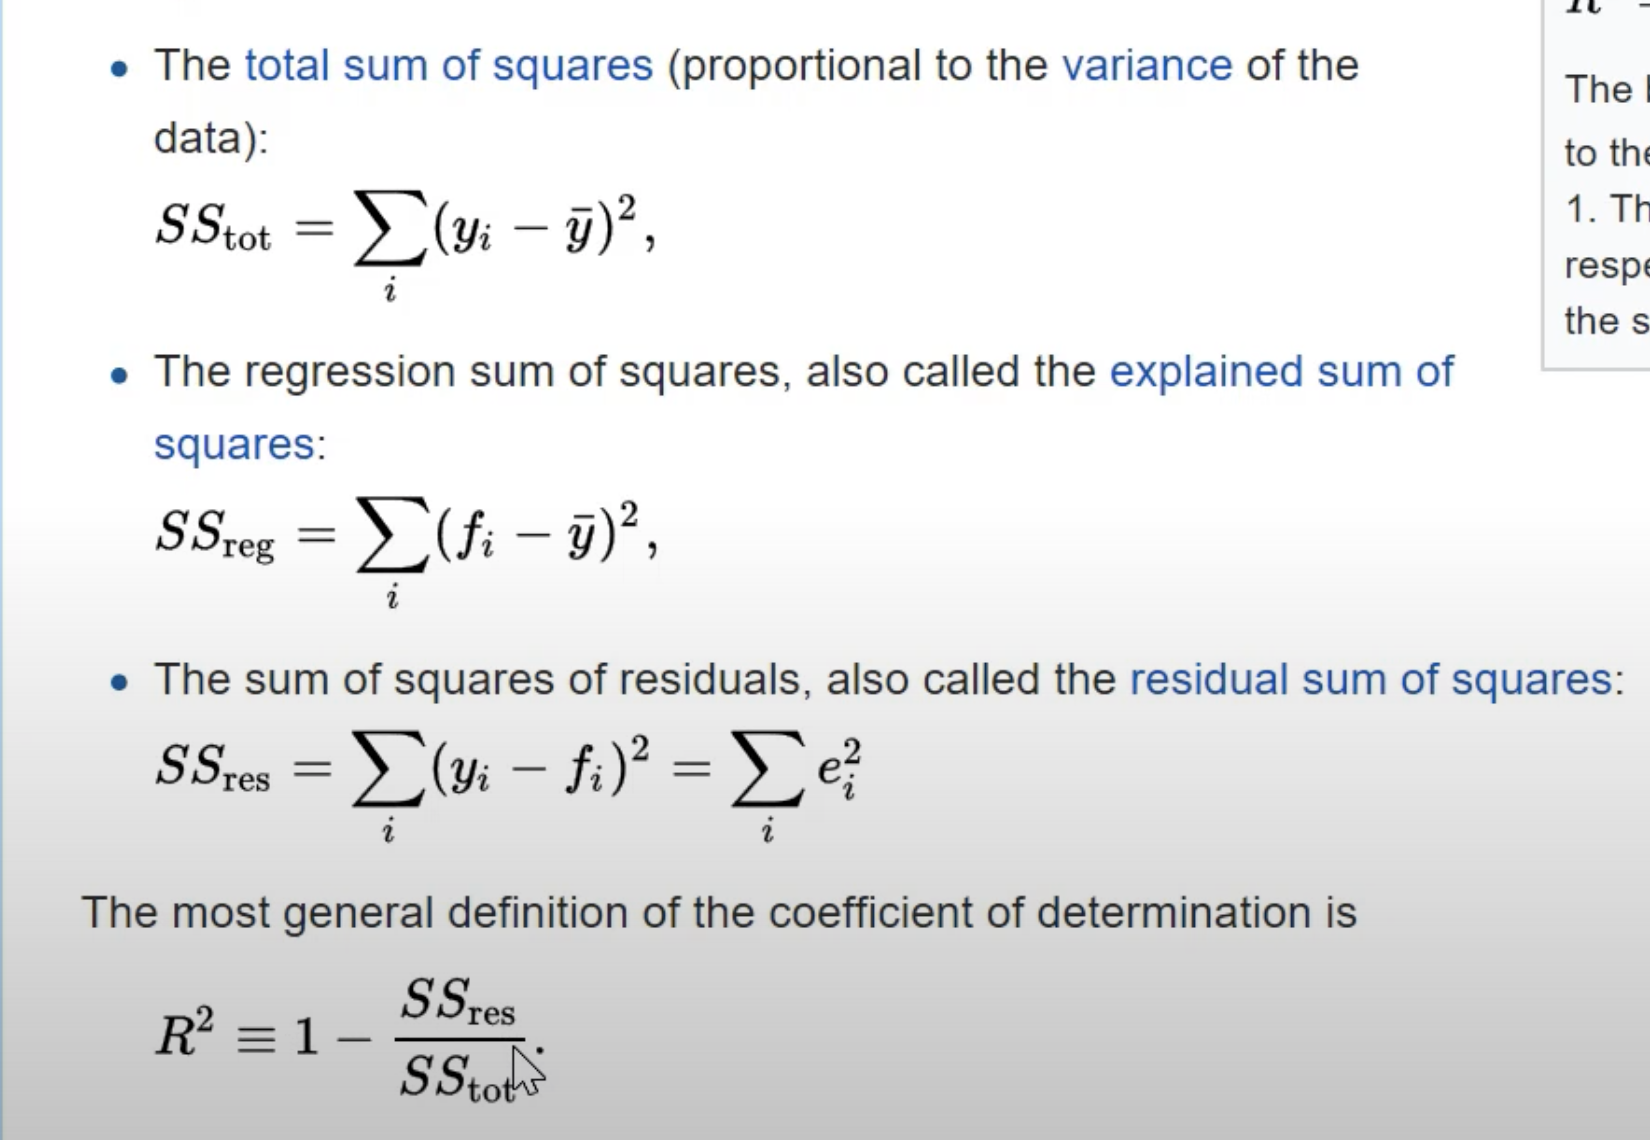

In [28]:
from IPython import display
display.Image('/Users/bablu/Desktop/image1.png')

checking for under/overfitting of the model

validation set helps diagnose this problem

In [29]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000 # same as test size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

#### Base Model

train model with separate training and validation sets.

In [30]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [31]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 14min 29s, sys: 5.43 s, total: 14min 34s
Wall time: 1min 22s
[0.07571624395972475, 0.23628989423437452, 0.9880184515067484, 0.9002901025033112]


Subsetting data

In [32]:
df_trn, y_trn = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [33]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 27.7 s, sys: 164 ms, total: 27.9 s
Wall time: 2.56 s
[0.09338122787661564, 0.338494098689938, 0.9811177724454326, 0.7953790120602597]


In [34]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

Single Tree

In [35]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False ,n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 111 ms, sys: 7.27 ms, total: 118 ms
Wall time: 118 ms
[0.5252462836952029, 0.5809230293620881, 0.40260711843311414, 0.3973222463809103]


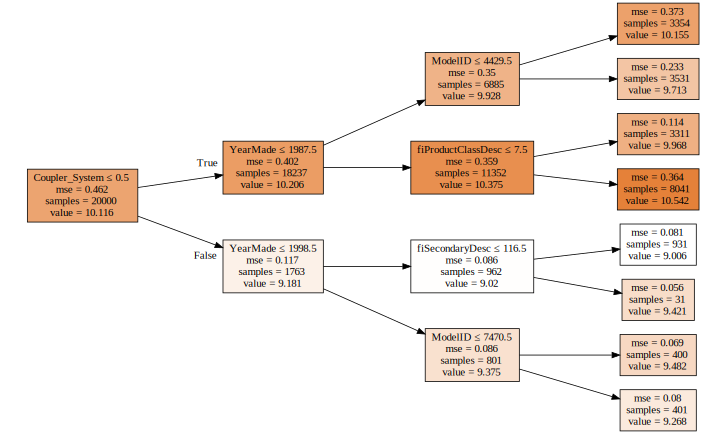

In [36]:
# lowest splits to largest splits, we tried every variable and every possible split 
# and find variable with max mse 
draw_tree(m.estimators_[0], df_trn, precision=3)

In [38]:
# bigger tree
m = RandomForestRegressor(n_estimators=1, bootstrap=False ,n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 341 ms, sys: 9.5 ms, total: 350 ms
Wall time: 350 ms
[3.7682219008410604e-17, 0.47937026340176747, 1.0, 0.5896162513731238]


Forest - Bagging (averaging models, also called as ensembling)

starting with 10 trees

In [45]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.36 s, sys: 28.4 ms, total: 2.39 s
Wall time: 323 ms
[0.11339328962684743, 0.3582042609738408, 0.9721574648821818, 0.7708554833081658]


we'll grab the predictions for each individual tree and look at one example, extratreesregressor also does same job, it randomly tries few split and few variables - better generalization. Each node is predicts the average value.

We basically train model until each leaf node as one split, practically we will have same number of leaf nodes as the number of rows in the dataset, we will have multiple trees which we average together.

In [46]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.41328122,  8.93590353,  9.39266193,  8.9226583 ,  9.15904708,
         8.93590353,  9.15904708,  9.41328122,  9.35010231, 10.04324949]),
 9.272513567722902,
 9.104979856318357)

In [47]:
preds.shape

(10, 12000)

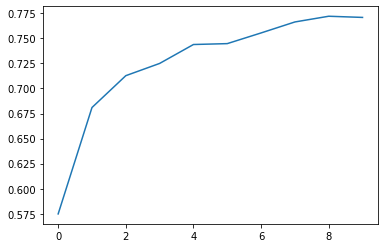

In [48]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

### out of bag score

we can pass those unused rows from tress and treat it as validation set and continous for different validations for each tree, we calc pred we will avg all trees where all that rows are not used for training 

In [49]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 10.1 s, sys: 107 ms, total: 10.2 s
Wall time: 1.23 s
[0.09635674460371701, 0.33928623468397345, 0.9798952672367238, 0.794420192942416, 0.855420927647148]


to find these hyperparameters automatically we use grid search

## Reducing overfitting

In [50]:
 # subsampling
"""
It turns out that one of the easiest ways to avoid overfitting is also one of the best ways to
speed up analysis: subsampling. Let's return to using our full dataset, so we can demonstrate 
the impact of the technique.
"""

df_trn, y_trn = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [51]:
len(df_trn)

401125

In [64]:
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [62]:
def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [56]:
set_rf_samples(20000)

In [59]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 14min 31s, sys: 5.95 s, total: 14min 37s
Wall time: 1min 30s
[0.07574218642730254, 0.23485014208302726, 0.988010239684115, 0.901501497348282, 0.9129400644457203]


In [58]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 39s, sys: 3.41 s, total: 5min 43s
Wall time: 39.1 s
[0.07853809277515175, 0.2406570563177367, 0.9871087352600209, 0.8965703215952857, 0.9083539034461325]


### Tree building parameters

we revert to using a full bootstrap sample in order to show the impact of other over fitting avoidance methods.

In [63]:
reset_rf_samples()

In [67]:
# baseline with 40 estimators for this full set to compare to 
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 42s, sys: 2.86 s, total: 5min 45s
Wall time: 39.1 s
[0.07820469874494461, 0.23597998119226413, 0.9872179497399952, 0.9005514859445113, 0.9087124662194271]


In [69]:
# this way we specify model to stop when leaves are less than 3
# there are less decision rules for each node; simpler models should generalize better
# predictions are made by averaging more rows in the leaf node, resulting in less volatility
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 1s, sys: 1.98 s, total: 5min 3s
Wall time: 34.1 s
[0.11514890936357125, 0.23575956548342214, 0.9722888541677469, 0.9007371777771653, 0.9082070982225249]


In [70]:
"""
less correlated your trees are the better, 
in addition to just take a subset of rows at every single subset we take different columns

default we use all of them, but we can specify 
in int, float(percentages), auto, sqrt, log2, none(max features)
1, 0.5, log2 or sqrt are commonly used
"""

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                          max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)


CPU times: user 2min 48s, sys: 1.47 s, total: 2min 49s
Wall time: 20.4 s
[0.11919419053091868, 0.22910123844545846, 0.970307620455611, 0.9062647703622041, 0.911602221306018]
